The aim of this notebook is to demonstrate the `EvalEmbeddings()` class, and how it can be used to evaluate the results of an embedding obtained based on the integration method that will be developed.

We'll use a super simple baseline, which will just be concatenating the PCA embeddings of the two modalities together - and use this 40 dimensional embedding for evaluation and visualizing the evaluation. 

The metrics used for evaluation are the ARI, AMI, Homogeneity and Completeness. These are four metrics which measure the correspondence of the clustering of the embedding with the ground-truth celltypes in different ways. We'll get their statistics for each and also average them. 

We'll consider two subsets of clustering and ground-truth label comparison:

1) The cell-type comparison - this is direct, we're essentially just seeing how well our embeddings recapitulate the ground-truth cell-types based on clustering

2) The batch comparison - here, we're seeing how well the batches mix in our embedding. We don't want our embedding to be suseptible to technical effects. So we take (1 - score) for all of these metrics (because we **don't** want batches to separate) - go over on chalkboard if this is not clear. 

For a total score, we use $Total = Avg(Cell-type metrics)*0.6 + Avg(Batch metrics)*0.4$  

Let's go ahead and load the libraries we used in **notebook 02**

In [1]:
import os

import numpy as np
import pandas as pd
import scanpy as sc 
import anndata as ann
import episcanpy as esc

Let's load the data

In [2]:
os.chdir("..")
multiome = sc.read_h5ad("data/multimodal/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")

Now we're going to separate the two modalities and get PCA embeddings for each of them individually. Once we have these, we'll concatenate them together (20 PCA GEX + 20 PCA ATAC = 40 PCA). This concatenated representation will be our embedding to evaluate on and will serve as a very simple baseline. 

In [3]:
gex = multiome[:, multiome.var["feature_types"] == "GEX"] # Subset all data, not just the counts 
sc.pp.highly_variable_genes(gex, n_top_genes=2500, flavor="seurat_v3") # Feature selection
sc.pp.pca(gex, n_comps=20) # Perform PCA reduction of the data

Trying to set attribute `._uns` of view, copying.


Trying to set attribute `.var` of view, copying.

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



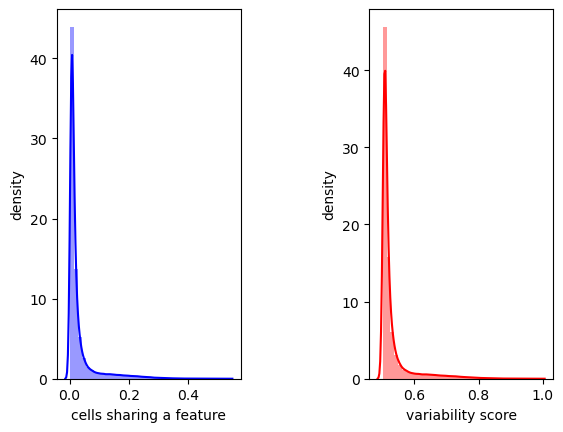

In [4]:
atac = multiome[:, multiome.var["feature_types"] == "ATAC"] # Subset all data, not just the counts 
esc.pp.select_var_feature(atac, nb_features=5000) # Feature-selection - most variable features
esc.pp.pca(atac, n_comps=20) # Just get the PCA - don't use the full lazy function

Let's take the top 20 PCs from both and concatenate them - viola we have a simple *embedding* to test

In [5]:
embedding_concat = np.concatenate(
    (
        gex.obsm["X_pca"][:, 0:20],
        atac.obsm["X_pca"][:, 0:20]
    ),
    axis = 1
)
embedding_concat.shape

(69249, 40)

So we can see that the shape is exactly what we wanted - our 69k total original cells and 40 dimensions of combined PCA (20 from GEX, 20 from ATAC). Now let's import our evaluation helper (please see the class code in the repository for the bells and whistles)

In [6]:
from helpers.eval_embeddings import EvalEmbeddings

In [7]:
help(EvalEmbeddings)

Help on class EvalEmbeddings in module helpers.eval_embeddings:

class EvalEmbeddings(builtins.object)
 |  EvalEmbeddings(adata)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, adata)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  evaluate(self, embeddings, leiden_res=1)
 |  
 |  plot(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



We can see that this function has to be initialized with the anndata object (this will be our combined ATAC + GEX anndata, although we can use just the gex here, since all we're doing is comparing with the cell-type and batch labels), and then we call `evaluate` using the embeddings we have, which will return the scores. After this, we can call `plot` to show the embeddings.

In [16]:
eval_obj = EvalEmbeddings(adata=gex) # Initialize the class

In [17]:
eval_obj.evaluate(embedding_concat)

(0.5494203095699718,
    celltype_ari  celltype_ami  celltype_homogeneity  celltype_complete  \
 0      0.202799      0.460792              0.504776           0.425152   
 
    batch_ari  batch_ami  batch_homogeneity  batch_complete  
 0   0.886302   0.742306           0.705142        0.770176  )

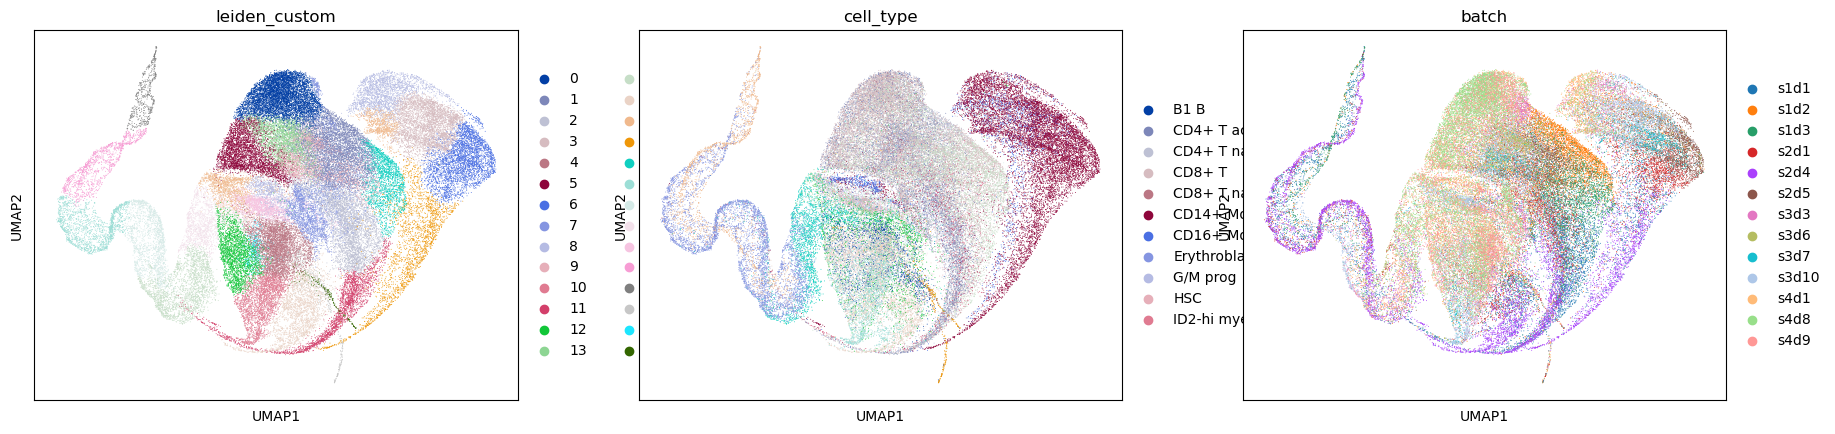

In [18]:
eval_obj.plot()